In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm

rng = np.random.default_rng()
FIG_PATH = Path('../figures')

In [2]:
def vals2map(vals):
    if vals.shape==(256,):
        map = vals.reshape(16, 16).copy()
    elif vals.shape==(1024,):
        offsets = [(0, 0), (0, 1), (1, 0), (1, 1)]
        assert vals.shape==(1024,)
        map = np.full((32, 32), fill_value=np.nan)
        for i, (y, x) in enumerate(offsets):
            map[y::2, x::2] = vals[i*256:(i+1)*256].reshape(16, 16)
    else:
        raise ValueError(f"Incorrect shape: {vals.shape}")
    return map

In [3]:
TILES = [
    '39491886', '48683828', '02187077', '19889837',
    '22652138', '25394938', '27832912', '31080823',
    '05454007', '09690755', '76995123', '98782621',
    '07586668', '80605801', '37721134', '39666903',
]

In [4]:
freq = 64

fvus = np.full((128, 128), fill_value=np.nan)
x = np.full((128, 128), fill_value=np.nan)
y = np.full((128, 128), fill_value=np.nan)
for i in range(4):
    for j in range(4):
        tile_idx = 4*i+j
        saved = torch.load('../cache/RF.fit_{}_[{:g}Hz].pt'.format(TILES[tile_idx], freq))

        fvus[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['fvus'])
        x[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['params_s'][:, 1])
        y[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['params_s'][:, 2])

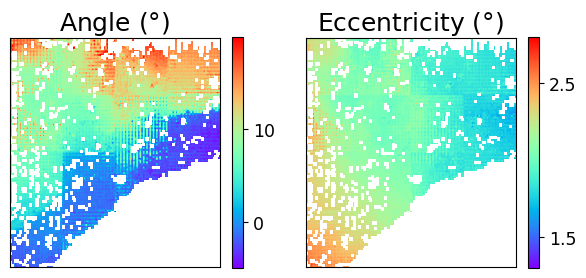

In [7]:
mask = fvus<0.8
angs = np.arctan2(x, y)/np.pi*180
eccs = (x**2+y**2)**0.5

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
for i, ax in enumerate(axes):
    if i==0:
        vals = angs.copy()
        vmin, vmax = -5, 20
        # vmin, vmax = -5, 30
        ticks = [0, 10]
        # ticks = [0, 10, 20]
        title = 'Angle'
    if i==1:
        vals = eccs.copy()
        vmin, vmax = 1.3, 2.8
        # vmin, vmax = 1.5, 3
        ticks = [1.5, 2.5]
        title = 'Eccentricity'
    vals[~mask] = np.nan
    # vmin, vmax = None, None
    h = ax.imshow(vals, extent=[0, 6.8, 0, 7.4], vmin=vmin, vmax=vmax, cmap='rainbow')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title+r' ($\degree$)')
    for sp in ax.spines.values():
        sp.set_visible(True)
    plt.colorbar(
        h, ax=ax, ticks=ticks,
        fraction=0.1
    )
fig.savefig(FIG_PATH/'rfs.center.dense_[{:g}Hz].svg'.format(freq))

plt.show()